In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError

# Read in data

In [2]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


In [3]:
labeled_data

In [4]:
vars(labeled_data).keys()

dict_keys(['data', 'row_weight', 'label', 'pred', 'days', 'with_varsom', 'regobs_types', 'single', 'seasons', 'with_regions'])

In [5]:
labeled_data.data.shape

(12651, 6562)

# Distributions of variables through all time and regions

I can look at how key variables are distributed for every region and all times. Then we can compare this to how how variables are distributed when clustering them by region or season.

In [6]:
# first, drop regions
labeled_data.data = labeled_data.drop_regions().data

# then, rename indices
labeled_data.data = labeled_data.data.rename_axis(['date','region'])
labeled_data.label = labeled_data.label.rename_axis(['date', 'region'])

# flatten the hierchy of columns to 1D
labeled_data.data.columns = [' '.join(col).strip().replace(' ', '_') for col in labeled_data.data.columns.values]
labeled_data.label.columns = [' '.join(col).strip().replace(' ', '_') for col in labeled_data.label.columns.values]

# convert some columns in labels to type int for averaging
labeled_data.label['CLASS__problem_amount'] = labeled_data.label['CLASS__problem_amount'].astype(int)
labeled_data.label['CLASS__danger_level'] = labeled_data.label['CLASS__danger_level'].astype(int)

for column in labeled_data.label.columns:
    if column.endswith(('_dist', '_dsize', '_lev_fill', '_prob', '_trig')):
        labeled_data.label[column] = labeled_data.label[column].astype(int)

In [7]:
labeled_data.data.head()

danger_level_1  danger_level_2  danger_level_3  \
date       region                                                   
2017-12-07 3003               1.0             1.0             1.0   
           3007               3.0             2.0             3.0   
           3009               3.0             2.0             2.0   
           3010               3.0             3.0             3.0   
           3011               3.0             3.0             3.0   

                   danger_level_4  danger_level_5  danger_level_6  \
date       region                                                   
2017-12-07 3003               1.0             1.0             1.0   
           3007               2.0             2.0             2.0   
           3009               2.0             2.0             2.0   
           3010               2.0             2.0             2.0   
           3011               2.0             2.0             2.0   

                   emergency_warning_1  emergency_warning_2  \
date       region                                             
2017-12-07 3003                    1.0                  1.0   
           3007                    1.0                  1.0   
           3009                    1.0                  1.0   
           3010                    1.0                  1.0   
           3011                    1.0                  1.0   

                   emergency_warning_3  emergency_warning_4  ...  \
date       region                                            ...   
2017-12-07 3003                    1.0                  1.0  ...   
           3007                    1.0                  1.0  ...   
           3009                    1.0                  1.0  ...   
           3010                    1.0                  1.0  ...   
           3011                    1.0                  1.0  ...   

                   regobs_snowprofile_t_min_4_4  regobs_snowprofile_t_min_4_5  \
date       region                                                               
2017-12-07 3003                             0.0                           0.0   
           3007                             0.0                           0.0   
           3009                             0.0                           0.0   
           3010                             0.0                           0.0   
           3011                             0.0                           0.0   

                   regobs_snowprofile_t_min_4_6  regobs_snowprofile_t_min_4_7  \
date       region                                                               
2017-12-07 3003                             0.0                           0.0   
           3007                             0.0                           0.0   
           3009                             0.0                           0.0   
           3010                             0.0                           0.0   
           3011                             0.0                           0.0   

                   accuracy_2  accuracy_3  accuracy_4  accuracy_5  accuracy_6  \
date       region                                                               
2017-12-07 3003           0.0         0.0         0.0         0.0         0.0   
           3007           0.0         0.0         0.0         0.0         0.0   
           3009           0.0         0.0         0.0         0.0         0.0   
           3010           0.0         0.0         0.0         0.0         0.0   
           3011           0.0         0.0         0.0         0.0         0.0   

                   accuracy_7  
date       region              
2017-12-07 3003           0.0  
           3007           0.0  
           3009           0.0  
           3010           0.0  
           3011           0.0  

[5 rows x 6516 columns]

In [8]:
labeled_data.label.head()

CLASS__danger_level CLASS__emergency_warning  \
date       region                                                 
2017-12-07 3003                      2                Ikke gitt   
           3007                      2                Ikke gitt   
           3009                      2                Ikke gitt   
           3010                      3                Ikke gitt   
           3011                      3                Ikke gitt   

                  CLASS__problem_1 CLASS__problem_2 CLASS__problem_3  \
date       region                                                      
2017-12-07 3003         drift-slab                                     
           3007           pwl-slab       drift-slab                    
           3009           pwl-slab       drift-slab                    
           3010         drift-slab         pwl-slab                    
           3011         drift-slab         pwl-slab                    

                   CLASS__problem_amount CLASS_drift-slab_cause  \
date       region                                                 
2017-12-07 3003                        1              snowdrift   
           3007                        2               new-snow   
           3009                        2               new-snow   
           3010                        2               new-snow   
           3011                        2               new-snow   

                   CLASS_drift-slab_dist  CLASS_drift-slab_dsize  \
date       region                                                  
2017-12-07 3003                        1                       2   
           3007                        2                       2   
           3009                        2                       2   
           3010                        3                       2   
           3011                        3                       2   

                   CLASS_drift-slab_lev_fill  ...  REAL_new-loose_lev_max  \
date       region                             ...                           
2017-12-07 3003                            1  ...                     0.0   
           3007                            1  ...                     0.0   
           3009                            1  ...                     0.0   
           3010                            1  ...                     0.0   
           3011                            1  ...                     0.0   

                   REAL_new-loose_lev_min REAL_new-slab_lev_max  \
date       region                                                 
2017-12-07 3003                       0.0                   0.0   
           3007                       0.0                   0.0   
           3009                       0.0                   0.0   
           3010                       0.0                   0.0   
           3011                       0.0                   0.0   

                   REAL_new-slab_lev_min  REAL_pwl-slab_lev_max  \
date       region                                                 
2017-12-07 3003                      0.0                    0.0   
           3007                      0.0                  700.0   
           3009                      0.0                  700.0   
           3010                      0.0                  700.0   
           3011                      0.0                  700.0   

                   REAL_pwl-slab_lev_min  REAL_wet-loose_lev_max  \
date       region                                                  
2017-12-07 3003                      0.0                     0.0   
           3007                    200.0                     0.0   
           3009                    200.0                     0.0   
           3010                    200.0                     0.0   
           3011                    200.0                     0.0   

                   REAL_wet-loose_lev_min REAL_wet-slab_lev_max  \
date       region                                                 
2017-1

In [9]:
labeled_data.data.mean().head(10)

danger_level_1         2.113983
danger_level_2         2.116908
danger_level_3         2.120781
danger_level_4         2.125445
danger_level_5         2.130583
danger_level_6         2.134614
emergency_warning_1    0.901984
emergency_warning_2    0.901035
emergency_warning_3    0.899929
emergency_warning_4    0.899376
dtype: float64

In [10]:
label_means_all = pd.DataFrame(labeled_data.label.mean()[labeled_data.label.mean() != np.infty])
label_means_all.columns = ['all_seasons']
label_means_all

,all_seasons
CLASS__danger_level,2.111296
CLASS__problem_amount,1.582958
CLASS_drift-slab_dist,1.089005
CLASS_drift-slab_dsize,1.263457
CLASS_drift-slab_lev_fill,0.589519
CLASS_drift-slab_prob,1.790530
CLASS_drift-slab_trig,10.688009
CLASS_glide_dist,0.070666
CLASS_glide_dsize,0.152004
CLASS_glide_lev_fill,0.125445


In [11]:
label_means_all.shape

(51, 1)

# Clustering data by region and time

I am interested in understanding how certain input variables are correlated to the output variables of interest. This includes how different snow pack conditions vary with avlanche problems and danger level warnings, but also how these input and output variables change with time, across different regions, etc.

The data is formatted as a MultiIndex in Pandas. This means we can first subset by time, then by region ID.

### By time

In [12]:
# look at df from one day, there should be 21 regions
labeled_data.data.loc['2017-12-07'].shape

(21, 6516)

In [13]:
labeled_data.data.loc['2017-12-07']

,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,,,,,,,,,,,,,,,,,,,,,
3003,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,3.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3009,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3010,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3011,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3012,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3013,3.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3014,2.0,3.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3015,3.0,3.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
labeled_data.data.loc['2017-12-07'].mean().head(6)

danger_level_1    2.666667
danger_level_2    2.761905
danger_level_3    2.476190
danger_level_4    2.285714
danger_level_5    2.142857
danger_level_6    1.761905
dtype: float64

In [15]:
labeled_data.data.loc['2017-12-07']

,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,,,,,,,,,,,,,,,,,,,,,
3003,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,3.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3009,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3010,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3011,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3012,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3013,3.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3014,2.0,3.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3015,3.0,3.0,2.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
dates_list = list(labeled_data.data.index.get_level_values(0))
dates_list

['2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-07',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-08',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-09',
 '2017-12-10',
 '2017-12-10',
 '2017-12-10',
 '2017-12-

In [17]:
first_data = labeled_data.data.loc[:'2018-05-31']
second_data = labeled_data.data.loc['2018-12-06':'2019-05-31']
third_data = labeled_data.data.loc['2019-12-07':'2020-06-14']
fourth_data = labeled_data.data.loc['2020-12-07':]

first_labels = labeled_data.label.loc[:'2018-05-31']
second_labels = labeled_data.label.loc['2018-12-06':'2019-05-31']
third_labels = labeled_data.label.loc['2019-12-07':'2020-06-14']
fourth_labels = labeled_data.label.loc['2020-12-07':]

In [18]:
print('Dataframe for 2017-2018 season has {} data points.'.format(len(first_data)))
print('Dataframe for 2018-2019 season has {} data points.'.format(len(second_data)))
print('Dataframe for 2019-2020 season has {} data points.'.format(len(third_data)))
print('Dataframe for 2020-2021 season has {} data points.'.format(len(fourth_data)))

Dataframe for 2017-2018 season has 3697 data points.
Dataframe for 2018-2019 season has 3791 data points.
Dataframe for 2019-2020 season has 4312 data points.
Dataframe for 2020-2021 season has 851 data points.


In [19]:
length_all_seasons = len(first_data) + len(second_data) + len(third_data) + len(fourth_data)
assert(length_all_seasons == len(labeled_data.data))

In [20]:
first_labels.head()

CLASS__danger_level CLASS__emergency_warning  \
date       region                                                 
2017-12-07 3003                      2                Ikke gitt   
           3007                      2                Ikke gitt   
           3009                      2                Ikke gitt   
           3010                      3                Ikke gitt   
           3011                      3                Ikke gitt   

                  CLASS__problem_1 CLASS__problem_2 CLASS__problem_3  \
date       region                                                      
2017-12-07 3003         drift-slab                                     
           3007           pwl-slab       drift-slab                    
           3009           pwl-slab       drift-slab                    
           3010         drift-slab         pwl-slab                    
           3011         drift-slab         pwl-slab                    

                   CLASS__problem_amount CLASS_drift-slab_cause  \
date       region                                                 
2017-12-07 3003                        1              snowdrift   
           3007                        2               new-snow   
           3009                        2               new-snow   
           3010                        2               new-snow   
           3011                        2               new-snow   

                   CLASS_drift-slab_dist  CLASS_drift-slab_dsize  \
date       region                                                  
2017-12-07 3003                        1                       2   
           3007                        2                       2   
           3009                        2                       2   
           3010                        3                       2   
           3011                        3                       2   

                   CLASS_drift-slab_lev_fill  ...  REAL_new-loose_lev_max  \
date       region                             ...                           
2017-12-07 3003                            1  ...                     0.0   
           3007                            1  ...                     0.0   
           3009                            1  ...                     0.0   
           3010                            1  ...                     0.0   
           3011                            1  ...                     0.0   

                   REAL_new-loose_lev_min REAL_new-slab_lev_max  \
date       region                                                 
2017-12-07 3003                       0.0                   0.0   
           3007                       0.0                   0.0   
           3009                       0.0                   0.0   
           3010                       0.0                   0.0   
           3011                       0.0                   0.0   

                   REAL_new-slab_lev_min  REAL_pwl-slab_lev_max  \
date       region                                                 
2017-12-07 3003                      0.0                    0.0   
           3007                      0.0                  700.0   
           3009                      0.0                  700.0   
           3010                      0.0                  700.0   
           3011                      0.0                  700.0   

                   REAL_pwl-slab_lev_min  REAL_wet-loose_lev_max  \
date       region                                                  
2017-12-07 3003                      0.0                     0.0   
           3007                    200.0                     0.0   
           3009                    200.0                     0.0   
           3010                    200.0                     0.0   
           3011                    200.0                     0.0   

                   REAL_wet-loose_lev_min REAL_wet-slab_lev_max  \
date       region                                                 
2017-1

In [21]:
first_labels.tail()

CLASS__danger_level CLASS__emergency_warning  \
date       region                                                 
2018-05-31 3029                      1                Ikke gitt   
           3031                      1                Ikke gitt   
           3032                      1                Ikke gitt   
           3034                      1                Ikke gitt   
           3035                      1                Ikke gitt   

                  CLASS__problem_1 CLASS__problem_2 CLASS__problem_3  \
date       region                                                      
2018-05-31 3029          wet-loose                                     
           3031          wet-loose                                     
           3032          wet-loose                                     
           3034          wet-loose                                     
           3035          wet-loose                                     

                   CLASS__problem_amount CLASS_drift-slab_cause  \
date       region                                                 
2018-05-31 3029                        1                      0   
           3031                        1                      0   
           3032                        1                      0   
           3034                        1                      0   
           3035                        1                      0   

                   CLASS_drift-slab_dist  CLASS_drift-slab_dsize  \
date       region                                                  
2018-05-31 3029                        0                       0   
           3031                        0                       0   
           3032                        0                       0   
           3034                        0                       0   
           3035                        0                       0   

                   CLASS_drift-slab_lev_fill  ...  REAL_new-loose_lev_max  \
date       region                             ...                           
2018-05-31 3029                            0  ...                     0.0   
           3031                            0  ...                     0.0   
           3032                            0  ...                     0.0   
           3034                            0  ...                     0.0   
           3035                            0  ...                     0.0   

                   REAL_new-loose_lev_min REAL_new-slab_lev_max  \
date       region                                                 
2018-05-31 3029                       0.0                   0.0   
           3031                       0.0                   0.0   
           3032                       0.0                   0.0   
           3034                       0.0                   0.0   
           3035                       0.0                   0.0   

                   REAL_new-slab_lev_min  REAL_pwl-slab_lev_max  \
date       region                                                 
2018-05-31 3029                      0.0                    0.0   
           3031                      0.0                    0.0   
           3032                      0.0                    0.0   
           3034                      0.0                    0.0   
           3035                      0.0                    0.0   

                   REAL_pwl-slab_lev_min  REAL_wet-loose_lev_max  \
date       region                                                  
2018-05-31 3029                      0.0                  1200.0   
           3031                      0.0                  1200.0   
           3032                      0.0                  1500.0   
           3034                      0.0                  1200.0   
           3035                      0.0                  1500.0   

                   REAL_wet-loose_lev_min REAL_wet-slab_lev_max  \
date       region                                                 
2018-0

In [22]:
season_labels = [first_labels, second_labels, third_labels, fourth_labels]
season_label_means = [df.mean() for df in season_labels]

In [23]:
label_means_seasons = pd.concat(season_label_means, axis=1)
label_means_seasons.columns = ['2017-2018', '2018-2019', '2019-2020', '2020-2021']

drop_list = ['MULTI_wet-slab_aspect', 'MULTI_glide_aspect', 'MULTI_new-loose_aspect',
            'MULTI_new-slab_aspect', 'MULTI_pwl-slab_aspect', 'MULTI_wet-loose_aspect',
            'MULTI_wet-slab_aspect', 'MULTI_drift-slab_aspect', 'CLASS_glide_cause']

label_means_seasons = label_means_seasons.drop(index=drop_list)

In [103]:
compare_means = pd.concat([label_means_all, label_means_seasons], axis=1).T
compare_means

,CLASS__danger_level,CLASS__problem_amount,CLASS_drift-slab_dist,CLASS_drift-slab_dsize,CLASS_drift-slab_lev_fill,CLASS_drift-slab_prob,CLASS_drift-slab_trig,CLASS_glide_dist,CLASS_glide_dsize,CLASS_glide_lev_fill,...,REAL_new-loose_lev_max,REAL_new-loose_lev_min,REAL_new-slab_lev_max,REAL_new-slab_lev_min,REAL_pwl-slab_lev_max,REAL_pwl-slab_lev_min,REAL_wet-loose_lev_max,REAL_wet-loose_lev_min,REAL_wet-slab_lev_max,REAL_wet-slab_lev_min
all_seasons,2.111296,1.582958,1.089005,1.263457,0.589519,1.790530,10.688009,0.070666,0.152004,0.125445,...,6.537033,3.509604,103.572840,34.803573,234.092167,96.411351,229.562880,109.991305,89.099676,46.676152
2017-2018,2.105491,1.656749,1.018123,1.156072,0.553422,1.660265,9.725994,0.034623,0.083852,0.058967,...,3.976197,0.540979,106.221260,2.461455,293.751691,43.873411,251.879903,47.687314,79.875575,15.634298
2018-2019,2.052757,1.524664,0.973358,1.119757,0.514640,1.572672,9.561857,0.026114,0.062253,0.034556,...,8.150884,1.846479,136.164600,7.860723,221.709312,27.037721,245.054075,52.730150,87.338433,23.239251
2019-2020,2.276438,1.654917,1.299165,1.538033,0.676716,2.064239,12.669991,0.154685,0.319341,0.287106,...,8.024119,7.629870,74.002783,74.002783,193.645640,176.692950,236.085343,229.545455,114.448052,101.623377
2020-2021,1.560517,1.157462,0.847239,0.978848,0.638073,1.940071,9.841363,0.000000,0.000000,0.000000,...,2.937720,2.937720,96.709753,96.709753,235.017626,226.909518,30.552291,29.964747,8.578143,7.520564


Thank you to these two resources in helping me plot multiple dataframes side by side below:
- https://stackoverflow.com/questions/38106730/plotting-multiple-histograms-in-matplotlib-colors-or-side-by-side-bars
- https://www.thetopsites.net/article/53698519.shtml

In [119]:
def plot_label_dist(total_rows, total_cols, size, start, end):
    """
    Plot the distribution of values in the labels for a different column.
    
    Arguments:
       total_rows(int): number of subplots along y axis
       total_cols(int): number of subplots along x axis
       size(tuple): two integers, how big the Matplotlib plot should be
       start(int): column number to start plotting on
       end(int): column number to end plotting on
       
    Note:
        start - end should equal total_rows x total_cols
       
    Returns:
       None
    """
    row = 0
    col = 0

    fig, ax = plt.subplots(total_rows, total_cols, figsize=size)

    for i, column in enumerate(compare_means.columns[start:end]):

        list_of_dfs = [first_labels[column].values, second_labels[column].values,
                   third_labels[column].values, fourth_labels[column].values,]#labeled_data.label[col].values]

        hist_labels = ['first', 'second', 'third', 'fourth',]#, 'all']

        ax[row, col].hist(list_of_dfs, alpha=0.6, label=hist_labels)

        ax[row, col].set_title(column)
        ax[row, col].legend()

        if(col < 2):
            col += 1
        else: 
            col = 0

        if((i+1) % 3 == 0 and i > 0):
            row += 1

    plt.show()

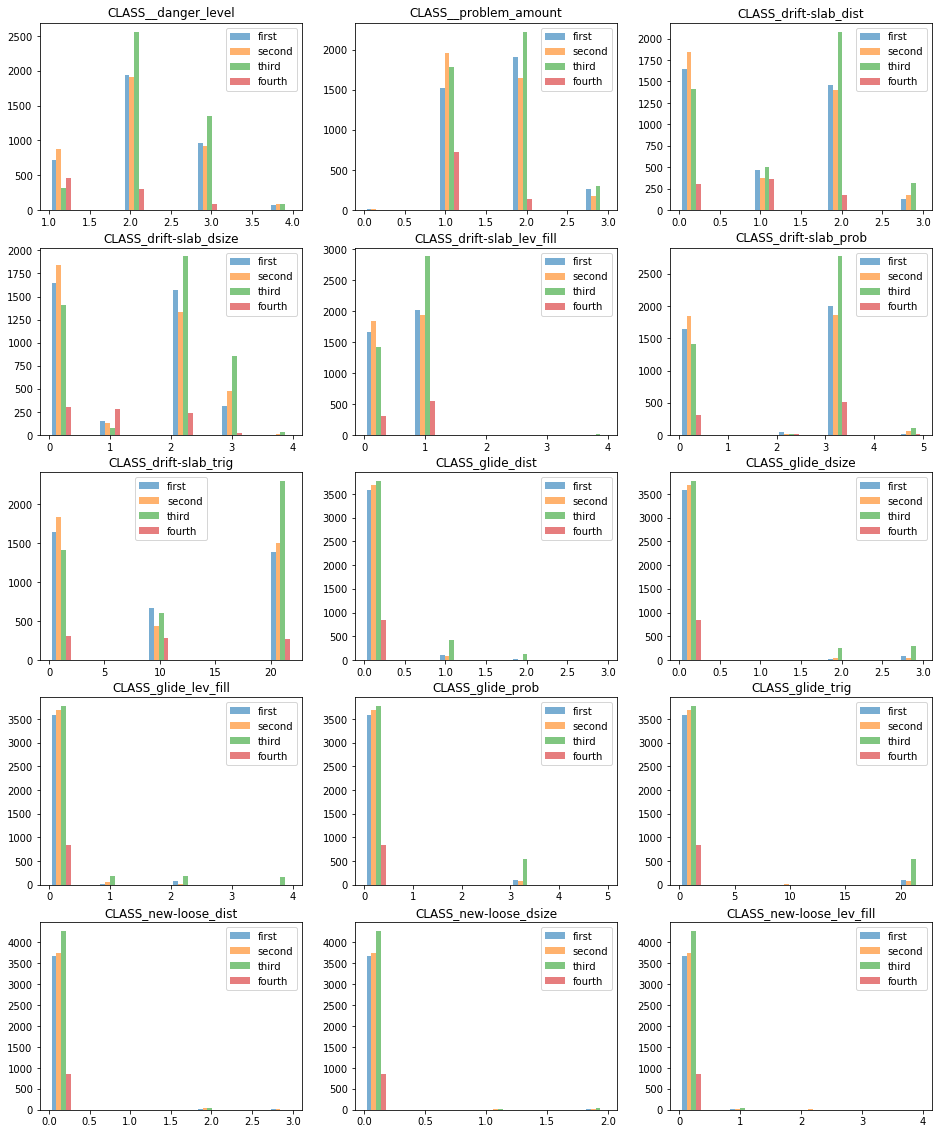

In [120]:
plot_label_dist(5, 3, (16, 20), 0, 15)

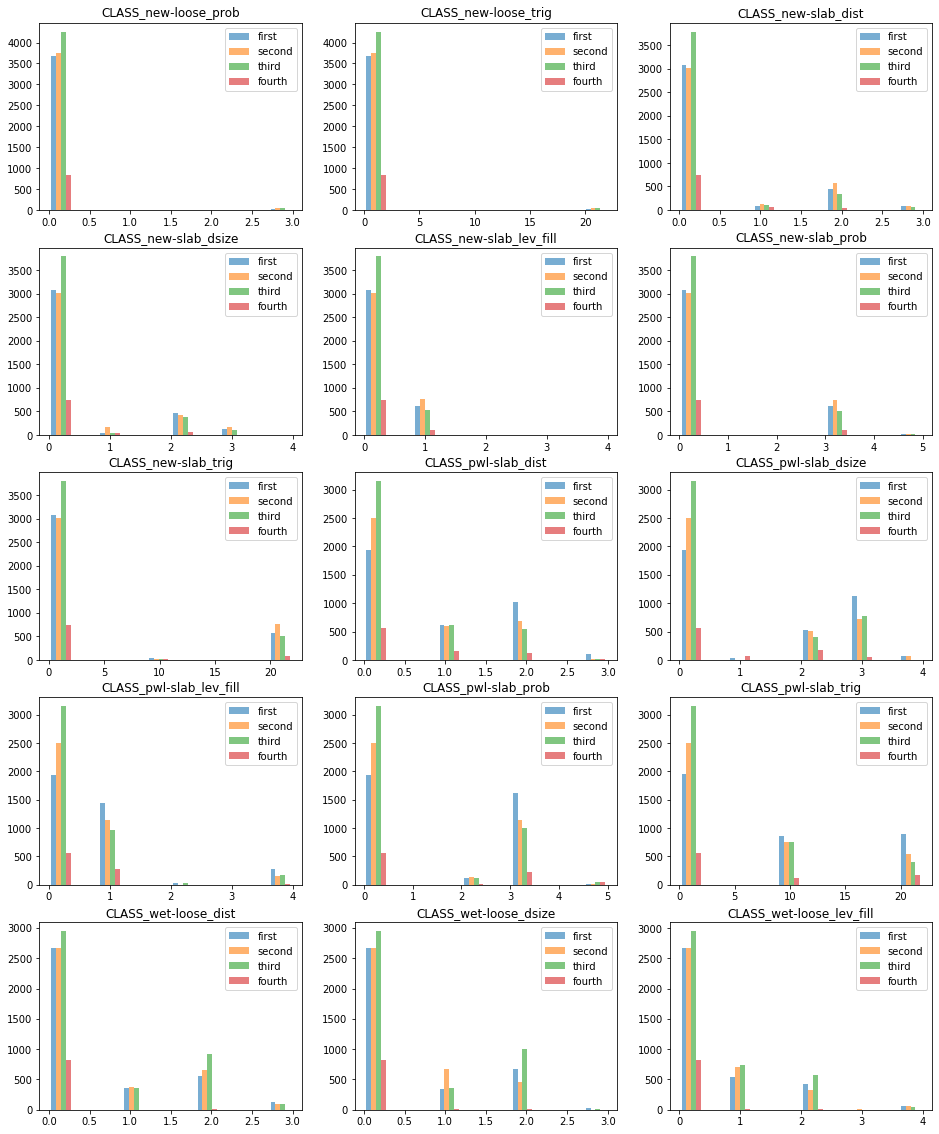

In [121]:
plot_label_dist(5, 3, (16, 20), 15, 30)

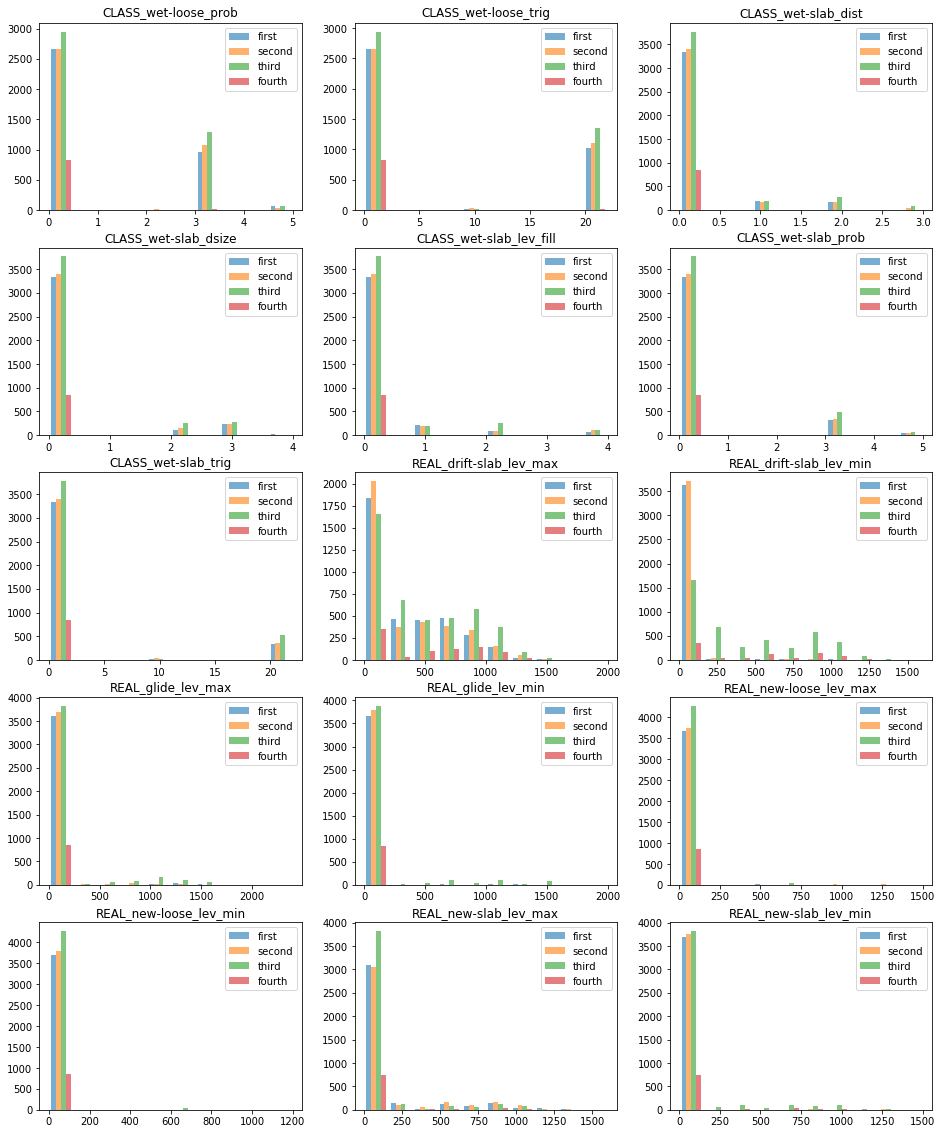

In [122]:
plot_label_dist(5, 3, (16, 20), 30, 45)

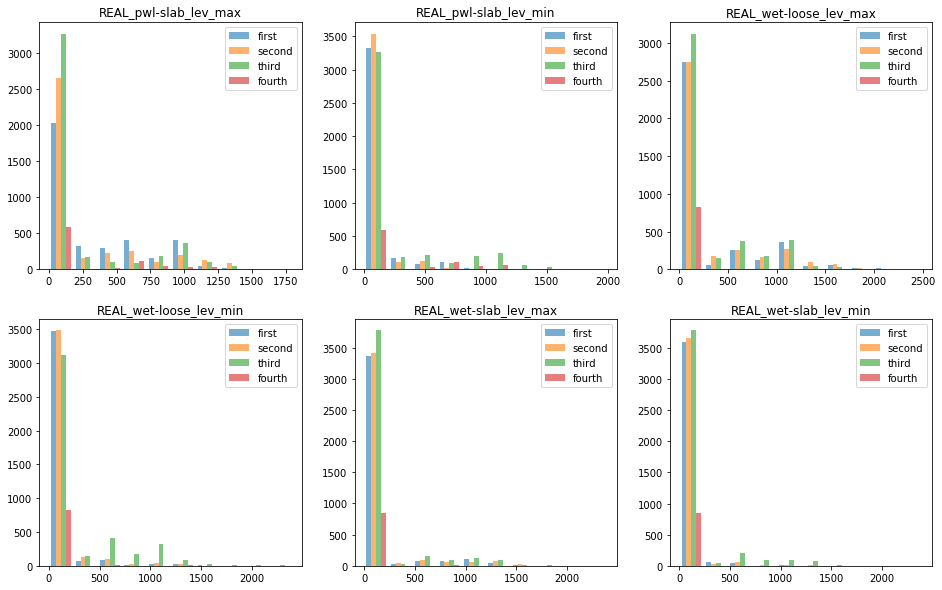

In [123]:
plot_label_dist(2, 3, (16, 10), 45, compare_means.shape[1])

So season 3 seems to be skewing the average. On several key variables, the 

### By region

To group by regions, we first need to reorder the indices of the MultiIndex object.

In [60]:
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

In [ ]:
regions_list = list(np.unique([region for region in labeled_data.data.loc['2017-12-07'].index]))
regions_list

In [27]:
region_3003 = regions.loc[3003]
region_3003

danger_level                          emergency_warning            \
                      1    2    3    4    5    6                 1    2    3   
date                                                                           
2017-12-07          1.0  1.0  1.0  1.0  1.0  1.0               1.0  1.0  1.0   
2017-12-08          2.0  1.0  1.0  1.0  1.0  1.0               1.0  1.0  1.0   
2017-12-09          2.0  2.0  1.0  1.0  1.0  1.0               1.0  1.0  1.0   
2017-12-10          2.0  2.0  2.0  1.0  1.0  1.0               1.0  1.0  1.0   
2017-12-11          2.0  2.0  2.0  2.0  1.0  1.0               1.0  1.0  1.0   
...                 ...  ...  ...  ...  ...  ...               ...  ...  ...   
2021-01-08          3.0  3.0  3.0  3.0  3.0  2.0               1.0  1.0  1.0   
2021-01-09          3.0  3.0  3.0  3.0  3.0  3.0               1.0  1.0  1.0   
2021-01-10          2.0  3.0  3.0  3.0  3.0  3.0               1.0  1.0  1.0   
2021-01-11          2.0  2.0  3.0  3.0  3.0  3.0               1.0  1.0  1.0   
2021-01-12          2.0  2.0  2.0  3.0  3.0  3.0               1.0  1.0  1.0   

                 ... regobs_snowprofile_t_min_4                accuracy       \
              4  ...                          4    5    6    7        2    3   
date             ...                                                           
2017-12-07  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
2017-12-08  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
2017-12-09  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
2017-12-10  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
2017-12-11  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
...         ...  ...                        ...  ...  ...  ...      ...  ...   
2021-01-08  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
2021-01-09  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
2021-01-10  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
2021-01-11  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
2021-01-12  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   

                                
              4    5    6    7  
date                            
2017-12-07  0.0  0.0  0.0  0.0  
2017-12-08  0.0  0.0  0.0  0.0  
2017-12-09  0.0  0.0  0.0  0.0  
2017-12-10  0.0  0.0  0.0  0.0  
2017-12-11  0.0  0.0  0.0  0.0  
...         ...  ...  ...  ...  
2021-01-08  0.0  0.0  0.0  0.0  
2021-01-09  0.0  0.0  0.0  0.0  
2021-01-10  0.0  0.0  0.0  0.0  
2021-01-11  0.0  0.0  0.0  0.0  
2021-01-12  0.0  0.0  0.0  0.0  

[568 rows x 6516 columns]

In [50]:
region_3003.tail()

danger_level                          emergency_warning            \
                      1    2    3    4    5    6                 1    2    3   
date                                                                           
2021-01-08          3.0  3.0  3.0  3.0  3.0  2.0               1.0  1.0  1.0   
2021-01-09          3.0  3.0  3.0  3.0  3.0  3.0               1.0  1.0  1.0   
2021-01-10          2.0  3.0  3.0  3.0  3.0  3.0               1.0  1.0  1.0   
2021-01-11          2.0  2.0  3.0  3.0  3.0  3.0               1.0  1.0  1.0   
2021-01-12          2.0  2.0  2.0  3.0  3.0  3.0               1.0  1.0  1.0   

                 ... regobs_snowprofile_t_min_4                accuracy       \
              4  ...                          4    5    6    7        2    3   
date             ...                                                           
2021-01-08  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
2021-01-09  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
2021-01-10  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
2021-01-11  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   
2021-01-12  1.0  ...                        0.0  0.0  0.0  0.0      0.0  0.0   

                                
              4    5    6    7  
date                            
2021-01-08  0.0  0.0  0.0  0.0  
2021-01-09  0.0  0.0  0.0  0.0  
2021-01-10  0.0  0.0  0.0  0.0  
2021-01-11  0.0  0.0  0.0  0.0  
2021-01-12  0.0  0.0  0.0  0.0  

[5 rows x 6516 columns]

In [61]:
label_3003 = labels.loc[3003]
label_3003

CLASS                                                    \
                                                                            
           danger_level emergency_warning   problem_1 problem_2 problem_3   
date                                                                        
2017-12-07            2         Ikke gitt  drift-slab                       
2017-12-08            2         Ikke gitt  drift-slab                       
2017-12-09            2         Ikke gitt  drift-slab                       
2017-12-10            2         Ikke gitt  drift-slab                       
2017-12-11            2         Ikke gitt  drift-slab                       
...                 ...               ...         ...       ...       ...   
2021-01-08            3         Ikke gitt  drift-slab  pwl-slab             
2021-01-09            2         Ikke gitt  drift-slab  pwl-slab             
2021-01-10            2         Ikke gitt  drift-slab  pwl-slab             
2021-01-11            2         Ikke gitt  drift-slab  pwl-slab             
2021-01-12            2         Ikke gitt  drift-slab  pwl-slab             

                                                          ...      REAL  \
                          drift-slab                      ... new-loose   
           problem_amount      cause dist dsize lev_fill  ...   lev_max   
date                                                      ...             
2017-12-07              1  snowdrift    1     2        1  ...       0.0   
2017-12-08              1   new-snow    1     2        1  ...       0.0   
2017-12-09              1  snowdrift    1     2        1  ...       0.0   
2017-12-10              1  snowdrift    1     2        1  ...       0.0   
2017-12-11              1   new-snow    2     2        1  ...       0.0   
...                   ...        ...  ...   ...      ...  ...       ...   
2021-01-08              2   new-snow    2     3        1  ...       0.0   
2021-01-09              2   new-snow    2     2        1  ...       0.0   
2021-01-10              2   new-snow    2     2        1  ...       0.0   
2021-01-11              2   new-snow    2     2        1  ...       0.0   
2021-01-12              2   new-snow    2     2        1  ...       0.0   

                                                                        \
                   new-slab         pwl-slab         wet-loose           
           lev_min  lev_max lev_min  lev_max lev_min   lev_max lev_min   
date                                                                     
2017-12-07     0.0      0.0     0.0      0.0     0.0       0.0     0.0   
2017-12-08     0.0      0.0     0.0      0.0     0.0       0.0     0.0   
2017-12-09     0.0      0.0     0.0      0.0     0.0       0.0     0.0   
2017-12-10     0.0      0.0     0.0      0.0     0.0       0.0     0.0   
2017-12-11     0.0      0.0     0.0      0.0     0.0       0.0     0.0   
...            ...      ...     ...      ...     ...       ...     ...   
2021-01-08     0.0      0.0     0.0    100.0   100.0       0.0     0.0   
2021-01-09     0.0      0.0     0.0    100.0   100.0       0.0     0.0   
2021-01-10     0.0      0.0     0.0    100.0   100.0       0.0     0.0   
2021-01-11     0.0      0.0     0.0    100.0   100.0       0.0     0.0   
2021-01-12     0.0      0.0     0.0    100.0   100.0       0.0     0.0   

                             
           wet-slab          
            lev_max lev_min  
date                         
2017-12-07      0.0     0.0  
2017-12-08      0.0     0.0  
2017-12-09      0.0     0.0  
2017-12-10      0.0     0.0  
2017-12-11      0.0     0.0  
...             ...     ...  
2021-01-08      0.0     0.0  
2021-01-09      0.0     0.0  
2021-01-10      0.0     0.0  
2021-01-11      0.0     0.0  
2021-01-12      0.0     0.0  

[568 rows x 69 columns]

In [49]:
index1 = list(set([column[0] for column in region_3003.columns]))

print(len(index1))
index1

1086


['regobs_event_valid_exposition_se_4',
 'regobs_tests_compr_test_fracture_0',
 'regobs_snowpack_snow_surface_tid_soft_wind_3',
 'regobs_problem_valid_exposition_ne_2',
 'regobs_problem_avalanche_ext_tid_glide_3',
 'regobs_event_avalanche_tid_wet_loose_1',
 'regobs_activity_valid_exposition_e_4',
 'regobs_snowprofile_t_max_2',
 'regobs_activity_avalanche_ext_tid_slush_4',
 'regobs_event_destructive_size_0',
 'regobs_snowpack_snow_surface_tid_hard_wind_0',
 'problem_pwl-slab_cause_ground-water',
 'regobs_event_terrain_start_zone_tid_lee_1',
 'regobs_snowpack_surface_water_content_1',
 'regobs_event_avalanche_trigger_tid_snowmobile_4',
 'regobs_event_avalanche_trigger_tid_remote_1',
 'regobs_problem_aval_cause_crystal_4',
 'regobs_tests_propagation_t_name_ectpv_3',
 'regobs_activity_exposed_height_combo_tid_middle-black_3',
 'regobs_tests_propagation_t_name_cth_1',
 'regobs_dangersign_danger_sign_tid_whumpf_1',
 'regobs_problem_aval_cause_tid_water-layers_1',
 'regobs_dangersign_danger_si

In [62]:
label_3003.columns

MultiIndex([('CLASS',           '',      'danger_level'),
            ('CLASS',           '', 'emergency_warning'),
            ('CLASS',           '',         'problem_1'),
            ('CLASS',           '',         'problem_2'),
            ('CLASS',           '',         'problem_3'),
            ('CLASS',           '',    'problem_amount'),
            ('CLASS', 'drift-slab',             'cause'),
            ('CLASS', 'drift-slab',              'dist'),
            ('CLASS', 'drift-slab',             'dsize'),
            ('CLASS', 'drift-slab',          'lev_fill'),
            ('CLASS', 'drift-slab',              'prob'),
            ('CLASS', 'drift-slab',              'trig'),
            ('CLASS',      'glide',             'cause'),
            ('CLASS',      'glide',              'dist'),
            ('CLASS',      'glide',             'dsize'),
            ('CLASS',      'glide',          'lev_fill'),
            ('CLASS',      'glide',              'prob'),
            ('

**TO DO**
- look at seasons distribution (clustered by year) of danger level, avalanche problem, snow distribution, temperature distribution, etc.

- then do the same thing for clusters of region: how are danger level, avalanche problem, snow and temperature distribution affected (so all years lumped into one dataset)

Now we could average over columns, sum, etc. We could try to count, as well, for histograms.

Could we embed a picture of Norway, and then map these averages or sums onto the avlanche regions? Are the avalanche regions in a format that GeoPandas can read in?

In [29]:
regions.groupby(level=0).sum()

region_id_3001 region_id_3002 region_id_3003 region_id_3004  \
                  0              0              0              0   
3003            0.0            0.0          568.0            0.0   
3006            0.0            0.0            0.0            0.0   
3007            0.0            0.0            0.0            0.0   
3009            0.0            0.0            0.0            0.0   
3010            0.0            0.0            0.0            0.0   
3011            0.0            0.0            0.0            0.0   
3012            0.0            0.0            0.0            0.0   
3013            0.0            0.0            0.0            0.0   
3014            0.0            0.0            0.0            0.0   
3015            0.0            0.0            0.0            0.0   
3016            0.0            0.0            0.0            0.0   
3017            0.0            0.0            0.0            0.0   
3022            0.0            0.0            0.0            0.0   
3023            0.0            0.0            0.0            0.0   
3024            0.0            0.0            0.0            0.0   
3027            0.0            0.0            0.0            0.0   
3028            0.0            0.0            0.0            0.0   
3029            0.0            0.0            0.0            0.0   
3031            0.0            0.0            0.0            0.0   
3032            0.0            0.0            0.0            0.0   
3034            0.0            0.0            0.0            0.0   
3035            0.0            0.0            0.0            0.0   
3037            0.0            0.0            0.0            0.0   

     region_id_3005 region_id_3006 region_id_3007 region_id_3008  \
                  0              0              0              0   
3003            0.0            0.0            0.0            0.0   
3006            0.0          161.0            0.0            0.0   
3007            0.0            0.0          580.0            0.0   
3009            0.0            0.0            0.0            0.0   
3010            0.0            0.0            0.0            0.0   
3011            0.0            0.0            0.0            0.0   
3012            0.0            0.0            0.0            0.0   
3013            0.0            0.0            0.0            0.0   
3014            0.0            0.0            0.0            0.0   
3015            0.0            0.0            0.0            0.0   
3016            0.0            0.0            0.0            0.0   
3017            0.0            0.0            0.0            0.0   
3022            0.0            0.0            0.0            0.0   
3023            0.0            0.0            0.0            0.0   
3024            0.0            0.0            0.0            0.0   
3027            0.0            0.0            0.0            0.0   
3028            0.0            0.0            0.0            0.0   
3029            0.0            0.0            0.0            0.0   
3031            0.0            0.0            0.0            0.0   
3032            0.0            0.0            0.0            0.0   
3034            0.0            0.0            0.0            0.0   
3035            0.0            0.0            0.0            0.0   
3037            0.0            0.0            0.0            0.0   

     region_id_3009 region_id_3010  ... regobs_snowprofile_t_min_4        \
                  0              0  ...                          4     5   
3003            0.0            0.0  ...                      -11.4 -11.4   
3006            0.0            0.0  ...                        0.0   0.0   
3007            0.0            0.0  ...                        0.0   0.0   
3009          580.0            0.0  ...                        0.0   0.0   
3010            0.0          580.0  ...                      -13.0 -13.0   
3011            0.0            0.0  ...                      -13.7 -13.

In [25]:
for i, (name, group) in enumerate(regions.groupby(level=0)):
    #print(name, group)
    print(i, group.iloc[:, 1:3].head())

0                 region_id_3002 region_id_3003
                             0              0
3003 2017-12-07            0.0            1.0
     2017-12-08            0.0            1.0
     2017-12-09            0.0            1.0
     2017-12-10            0.0            1.0
     2017-12-11            0.0            1.0
1                 region_id_3002 region_id_3003
                             0              0
3006 2018-04-01            0.0            0.0
     2020-02-13            0.0            0.0
     2020-02-14            0.0            0.0
     2020-02-15            0.0            0.0
     2020-02-16            0.0            0.0
2                 region_id_3002 region_id_3003
                             0              0
3007 2017-12-07            0.0            0.0
     2017-12-08            0.0            0.0
     2017-12-09            0.0            0.0
     2017-12-10            0.0            0.0
     2017-12-11            0.0            0.0
3                 region_id_

# Make plots

I may need to normalize the input variables before I make the plots.